In [2]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

## Model Libraries
from sklearn.naive_bayes import BernoulliNB

In [3]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [4]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [5]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [6]:
X = df.iloc[:, 2:9]

In [7]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [8]:
for col in X:
    X[col] = X[col].astype(int)

In [9]:
X.head()

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,1,1,1,1,0,1,1
1,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,0,0,0,1,0,0
4,1,1,1,1,0,0,0


In [1]:
X.co

NameError: name 'X' is not defined

In [9]:
X.shape

(292, 7)

In [10]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [11]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

## Cross Validation & Hyperparameter Tuning
Adopted from: https://weina.me/nested-cross-validation/

#### Data Splitting

In [12]:
## Divide data into train and "unseen" test set
## Unseen test set will be used for final testing after best hyperparameter sets chose
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(X, y, test_size=0.30, random_state=42)

In [13]:
y_train.value_counts()

0    149
1     55
Name: label, dtype: int64

In [14]:
y_test_unseen.value_counts()

0    66
1    22
Name: label, dtype: int64

#### Find The Best Hyperparameter Candidates

In [15]:
## Define a parameters grid
p_grid = {"alpha": [0.5,1.0], "fit_prior": [True, False]}

In [16]:
## Split train data to 5 (outer) folds
skfold_outer = StratifiedKFold(n_splits=5)
skfold_inner = StratifiedKFold(n_splits=4)

In [17]:
i = 1
folds = []
for train_index_outer, test_index_outer in skfold_outer.split(X_train, y_train):
    fold_data = {}
    
    print("Outer Fold %s" % i)
    data_X_train = X_train.iloc[train_index_outer]
    data_y_train = y_train.iloc[train_index_outer]
    data_X_test = X_train.iloc[test_index_outer]
    data_y_test = y_train.iloc[test_index_outer]
    
    ## Define model
    model = BernoulliNB()
    
    ## Do cross validation in inner fold, get the best params
    clf = GridSearchCV(model, p_grid, scoring='roc_auc', cv=skfold_inner)
    clf.fit(data_X_train, data_y_train)
    print("Best Params: %s" % clf.best_params_)
    print("Best Avg. Score: %s" % clf.best_score_)
    fold_data['outer_fold'] = i
    fold_data['best_param'] = clf.best_params_
    fold_data['best_avg_score'] = clf.best_score_
    
    ## Test to test data in outer loop
    model = BernoulliNB(alpha=fold_data['best_param']['alpha'],\
                        fit_prior=fold_data['best_param']['fit_prior'])
    
    model.fit(data_X_train, data_y_train)
    y_pred_proba = model.predict_proba(data_X_test)
    fpr, tpr, thresholds = roc_curve(data_y_test, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    fold_data['test_outer_score'] = auc_score
    print("Test Outer Score: %s" % auc_score)
    
    folds.append(fold_data)
    
    i+=1

Outer Fold 1
Best Params: {'alpha': 1.0, 'fit_prior': True}
Best Avg. Score: 0.9234979101358413
Test Outer Score: 0.9636363636363636
Outer Fold 2
Best Params: {'alpha': 0.5, 'fit_prior': True}
Best Avg. Score: 0.9466039707419017
Test Outer Score: 0.8772727272727273
Outer Fold 3
Best Params: {'alpha': 1.0, 'fit_prior': True}
Best Avg. Score: 0.9318312434691746
Test Outer Score: 0.9303030303030303
Outer Fold 4
Best Params: {'alpha': 0.5, 'fit_prior': True}
Best Avg. Score: 0.9272074190177638
Test Outer Score: 0.9242424242424243
Outer Fold 5
Best Params: {'alpha': 0.5, 'fit_prior': True}
Best Avg. Score: 0.9223484848484849
Test Outer Score: 0.9561128526645768


In [18]:
folds

[{'outer_fold': 1,
  'best_param': {'alpha': 1.0, 'fit_prior': True},
  'best_avg_score': 0.9234979101358413,
  'test_outer_score': 0.9636363636363636},
 {'outer_fold': 2,
  'best_param': {'alpha': 0.5, 'fit_prior': True},
  'best_avg_score': 0.9466039707419017,
  'test_outer_score': 0.8772727272727273},
 {'outer_fold': 3,
  'best_param': {'alpha': 1.0, 'fit_prior': True},
  'best_avg_score': 0.9318312434691746,
  'test_outer_score': 0.9303030303030303},
 {'outer_fold': 4,
  'best_param': {'alpha': 0.5, 'fit_prior': True},
  'best_avg_score': 0.9272074190177638,
  'test_outer_score': 0.9242424242424243},
 {'outer_fold': 5,
  'best_param': {'alpha': 0.5, 'fit_prior': True},
  'best_avg_score': 0.9223484848484849,
  'test_outer_score': 0.9561128526645768}]

In [19]:
df_outer_fold_result = pd.DataFrame({"outer_fold":[], "alpha":[], "fit_prior":[], \
                                     "best_avg_score":[], "test_outer_score": []})
for fold in folds:
    res = pd.concat([pd.DataFrame(fold['best_param'], index=[0]),\
                    pd.DataFrame(fold, index=[0]).drop('best_param', axis=1)], axis=1)
    df_outer_fold_result = pd.concat([df_outer_fold_result, res])

In [20]:
print(df_outer_fold_result.iloc[:,:-1].to_latex(index=False))

\begin{tabular}{rrrr}
\toprule
 outer\_fold &  alpha &  fit\_prior &  best\_avg\_score \\
\midrule
        1.0 &    1.0 &        1.0 &        0.923498 \\
        2.0 &    0.5 &        1.0 &        0.946604 \\
        3.0 &    1.0 &        1.0 &        0.931831 \\
        4.0 &    0.5 &        1.0 &        0.927207 \\
        5.0 &    0.5 &        1.0 &        0.922348 \\
\bottomrule
\end{tabular}



#### Test All Candidates To Unseen Data

In [21]:
pred_class = []
pred_proba = []
pred_auc = []
for fold in folds:
    model = BernoulliNB(alpha=fold['best_param']['alpha'],\
                        fit_prior=fold['best_param']['fit_prior'])
    
    ## Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_unseen)
    y_pred_proba = model.predict_proba(X_test_unseen)
    
    ## Print metrics
    print("==============================")
    print("Fold %s" % fold['outer_fold'])
    print("Parameter: %s" % fold['best_param'])
    fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_test_unseen, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("AUC: %.3f" % auc_score)
    print("Accuracy: %.3f " % accuracy)
    print("Precision: %.3f " % precision)
    print("Recall: %.3f " % recall)
    print("F1 Score: %.3f " % f1_score)
    print("True Positive: %s" % tp)
    print("False Positive: %s" % fp)
    print("True Negative: %s" % tn)
    print("False Negative: %s" % fn)
    print("==============================")
    
    pred_class.append(y_pred)
    pred_proba.append(y_pred_proba)
    pred_auc.append(auc_score)

Fold 1
Parameter: {'alpha': 1.0, 'fit_prior': True}
AUC: 0.953
Accuracy: 0.864 
Precision: 0.679 
Recall: 0.864 
F1 Score: 0.760 
True Positive: 19
False Positive: 9
True Negative: 57
False Negative: 3
Fold 2
Parameter: {'alpha': 0.5, 'fit_prior': True}
AUC: 0.953
Accuracy: 0.875 
Precision: 0.704 
Recall: 0.864 
F1 Score: 0.776 
True Positive: 19
False Positive: 8
True Negative: 58
False Negative: 3
Fold 3
Parameter: {'alpha': 1.0, 'fit_prior': True}
AUC: 0.953
Accuracy: 0.864 
Precision: 0.679 
Recall: 0.864 
F1 Score: 0.760 
True Positive: 19
False Positive: 9
True Negative: 57
False Negative: 3
Fold 4
Parameter: {'alpha': 0.5, 'fit_prior': True}
AUC: 0.953
Accuracy: 0.875 
Precision: 0.704 
Recall: 0.864 
F1 Score: 0.776 
True Positive: 19
False Positive: 8
True Negative: 58
False Negative: 3
Fold 5
Parameter: {'alpha': 0.5, 'fit_prior': True}
AUC: 0.953
Accuracy: 0.875 
Precision: 0.704 
Recall: 0.864 
F1 Score: 0.776 
True Positive: 19
False Positive: 8
True Negative: 58
False Ne

In [22]:
## Result table all training data test to unseen test data
df_test_unseen_result = pd.DataFrame({"candidates": df_outer_fold_result['outer_fold'], \
                                      "alpha": df_outer_fold_result['alpha'], \
                                      "fit_prior": df_outer_fold_result['fit_prior'],\
                                      "test_unseen_score": pred_auc})
df_test_unseen_result

,candidates,alpha,fit_prior,test_unseen_score
0,1.0,1.0,1.0,0.953168
0,2.0,0.5,1.0,0.953168
0,3.0,1.0,1.0,0.953168
0,4.0,0.5,1.0,0.953168
0,5.0,0.5,1.0,0.953168


In [23]:
df_x = pd.concat([df_outer_fold_result.iloc[:,0:1] , df_outer_fold_result.iloc[:,-1:], df_test_unseen_result[['test_unseen_score']]], axis=1)

In [24]:
print(df_x.to_latex(index=False))

\begin{tabular}{rrr}
\toprule
 outer\_fold &  test\_outer\_score &  test\_unseen\_score \\
\midrule
        1.0 &          0.963636 &           0.953168 \\
        2.0 &          0.877273 &           0.953168 \\
        3.0 &          0.930303 &           0.953168 \\
        4.0 &          0.924242 &           0.953168 \\
        5.0 &          0.956113 &           0.953168 \\
\bottomrule
\end{tabular}



In [25]:
## Best hyperparameter test to unseen data
fold_best = folds[np.argmax(pred_auc)]

In [26]:
## Predict with the best params
model = BernoulliNB(alpha=fold_best['best_param']['alpha'],\
                    fit_prior=fold_best['best_param']['fit_prior'])        
model.fit(X_train, y_train)
y_pred = model.predict(X_test_unseen)
y_pred_proba = model.predict_proba(X_test_unseen)

In [27]:
fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test_unseen, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

AUC: 0.953
Accuracy: 0.864 
Precision: 0.679 
Recall: 0.864 
F1 Score: 0.760 
True Positive: 19
False Positive: 9
True Negative: 57
False Negative: 3


In [61]:
df_res = pd.DataFrame({""}, index=[0])
df_res['auc'] = auc_score
df_res['accuracy'] = accuracy
tnr = tn/(tn+fp)
df_res['balanced_accuracy'] = (recall + tnr)/2
df_res['precision'] = precision
df_res['recall'] = recall
df_res['f1_score'] = f1_score
df_res['confusion_matrix (tp,tn,fp,fn)'] = str([tp, tn, fp, fn])

In [62]:
df_res

,0,auc,accuracy,balanced_accuracy,precision,recall,f1_score,"confusion_matrix (tp,tn,fp,fn)"
0,,0.953168,0.863636,0.863636,0.678571,0.863636,0.76,"[19, 57, 9, 3]"


In [63]:
df_res.to_csv("res_nb.csv", index=False)

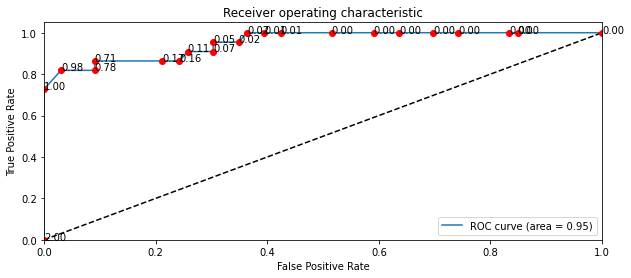

In [65]:
## ROC AUC Graph
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
for i in range(len(fpr)):
    plt.text(fpr[i], tpr[i], "%0.2f" % thresholds[i])
    plt.plot(fpr[i], tpr[i], 'ro')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

In [64]:
thresholds

array([1.99830492e+00, 9.98304921e-01, 9.81497985e-01, 7.81094235e-01,
       7.07783751e-01, 1.65859827e-01, 1.61381690e-01, 1.11864414e-01,
       7.36657566e-02, 4.74800713e-02, 1.68628147e-02, 1.62691552e-02,
       9.80518665e-03, 7.03811789e-03, 1.40608250e-03, 8.91138505e-04,
       3.68451534e-04, 1.88780979e-04, 1.86804760e-04, 1.26813062e-04,
       1.18339080e-04, 1.68290246e-05])

In [31]:
## Calculate feature importance by seeing empirical log probability of features given a class, P(x_i|y).
feat_log_prob_0 = model.feature_log_prob_[0]
feat_log_prob_1 = model.feature_log_prob_[1]
feat_name = X_train.columns.values

In [32]:
## Class prior
print(model.class_log_prior_)

[-0.31417369 -1.31078681]


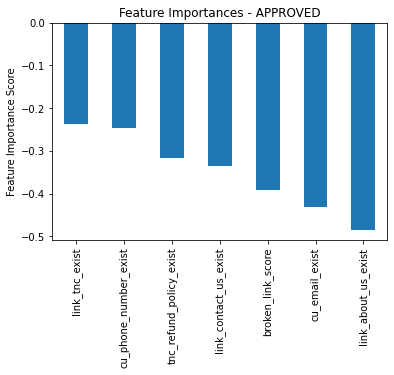

In [33]:
feat_imp = pd.Series(index=feat_name, data=feat_log_prob_0).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances - APPROVED')
plt.ylabel('Feature Importance Score')
plt.show()

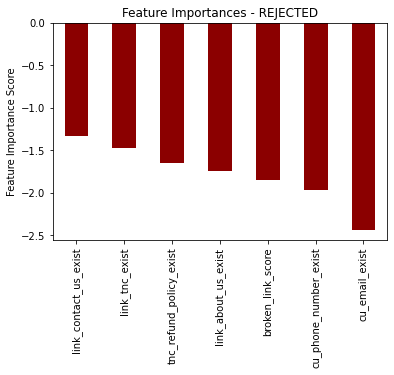

In [34]:
feat_imp = pd.Series(index=feat_name, data=feat_log_prob_1).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances - REJECTED', color='darkred')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [35]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/model.pickle', 'wb'))